## EDA (exploratory data analysis) notebook

Starting with Exploratory Data Analysis

In [1]:
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

import numpy as np
import os

2023-12-10 09:05:10.608285: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-10 09:05:10.608319: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-10 09:05:10.608342: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-10 09:05:10.614965: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/local/lib/python3.11/dist-packages/te

Check if GPU or CPU is used for training


In [2]:
if tf.config.list_physical_devices('GPU'):
    print("GPU is available")
else:
    print("GPU not available")

GPU is available


Set configuration to make reading the dataset reproducible

In [3]:
read_config = tfds.ReadConfig(
    shuffle_seed=42, 
    shuffle_reshuffle_each_iteration=True,
    )

data_dir = '/tensorflow_datasets'

Loading the dataset and checking the information

In [13]:
(ds_train_full, ds_test), ds_info = tfds.load(
    'rock_paper_scissors',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
    read_config=read_config,
    data_dir=data_dir,
)
ds_info

tfds.core.DatasetInfo(
    name='rock_paper_scissors',
    full_name='rock_paper_scissors/3.0.0',
    description="""
    Images of hands playing rock, paper, scissor game.
    """,
    homepage='http://laurencemoroney.com/rock-paper-scissors-dataset',
    data_dir='/tensorflow_datasets/rock_paper_scissors/3.0.0',
    file_format=tfrecord,
    download_size=219.53 MiB,
    dataset_size=219.23 MiB,
    features=FeaturesDict({
        'image': Image(shape=(300, 300, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=3),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=372, num_shards=1>,
        'train': <SplitInfo num_examples=2520, num_shards=2>,
    },
    citation="""@ONLINE {rps,
    author = "Laurence Moroney",
    title = "Rock, Paper, Scissors Dataset",
    month = "feb",
    year = "2019",
    url = "http://laurencemoroney.com/rock-paper-scissors-dataset"
    }""",
)

In [22]:
print(f"Number of training examples: {ds_info.splits['train'].num_examples}")
print(f"Number of test examples: {ds_info.splits['test'].num_examples}")
print(f"Ratio test data to (full) train data: {ds_info.splits['test'].num_examples / ds_info.splits['train'].num_examples:.2%}")

Number of training examples: 2520
Number of test examples: 372
Ratio test data to (full) train data: 14.76%


When comparing the amount of test data to the amount of training data, we can see that the test data is ~15% of the training data. Therefore we will use 15% of the training data as a validation set.

Loading the dataset but using a proportion of the training set to create a validation set.

In [5]:
# Calculate the number of validation samples (15% of training data)
num_train_samples = tf.data.experimental.cardinality(ds_train_full).numpy()
num_val_samples = int(num_train_samples * 0.15)

# Define the new training and validation splits
train_split = f'train[:{num_train_samples - num_val_samples}]'
val_split = f'train[-{num_val_samples}:]'

# Load the datasets
(ds_train, ds_val, ds_test) = tfds.load(
    'rock_paper_scissors',
    split=[train_split, val_split, 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=False,
    read_config=read_config,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/2520 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/rock_paper_scissors/3.0.0.incomplete6YDHN7/rock_paper_scissors-train.tfrec…

Generating test examples...:   0%|          | 0/372 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/rock_paper_scissors/3.0.0.incomplete6YDHN7/rock_paper_scissors-test.tfreco…

Dataset rock_paper_scissors downloaded and prepared to /root/tensorflow_datasets/rock_paper_scissors/3.0.0. Subsequent calls will reuse this data.


Check sizes of the splits. The "full train" refers to the initial training set, before taking a proportion of it to create the validation set.

In [6]:
# check sizes of splits
print("Full train size:", tf.data.experimental.cardinality(ds_train_full).numpy())
print("Train size     :", tf.data.experimental.cardinality(ds_train).numpy())
print("Validation size:", tf.data.experimental.cardinality(ds_val).numpy())
print("Test size      :", tf.data.experimental.cardinality(ds_test).numpy())

Full train size: 2520
Train size     : 2142
Validation size: 378
Test size      : 372


In [27]:
print("Image shape", ds_info.features["image"].shape)

Image shape (300, 300, 3)


Images are RGB images and have a size of `300x300` pixels.

Visualize some images from the training set and check how they are looking.

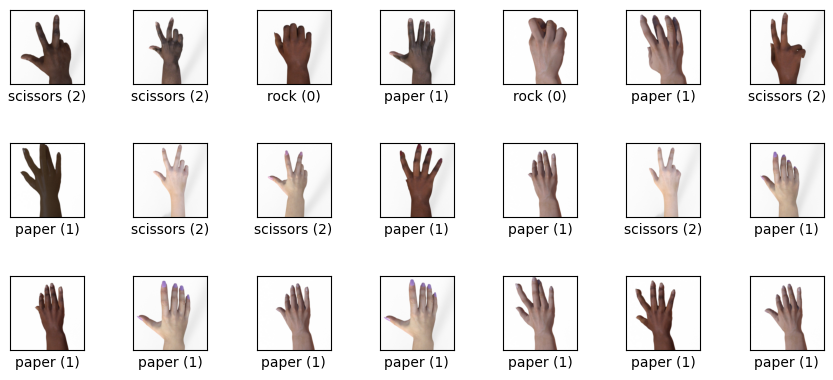

In [23]:
# # Visualize some examples
fig = tfds.show_examples(ds_train, ds_info, rows=3, cols=7, plot_scale=1.5)
# fig.savefig('rock_paper_scissors_examples.png', bbox_inches='tight')

We can see that the skin tones are diverse, but the background is not. 

The images seem all to have a bright background and the hands are in the center of the images. 

Furthermore the hands seem always to be fully visible in the images, but seem to have different scales. 

⚖️ We will now check the class balances.

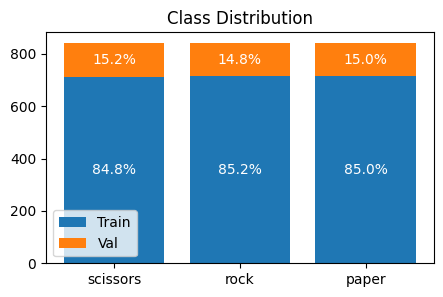

In [24]:
def get_class_distribution(ds):
    # Initialize a dictionary to hold the class counts
    class_counts = {}

    # Get the label names from ds_info
    label_names = ds_info.features['label'].names

    for _, label in ds:
        # Convert the label tensor to a Python integer
        label = label.numpy()

        # Get the label name
        label_name = label_names[label]

        # Increment the count for this label
        class_counts[label_name] = class_counts.get(label_name, 0) + 1

    return class_counts

# Get the class distributions for each dataset
train_counts = get_class_distribution(ds_train)
val_counts = get_class_distribution(ds_val)

# Get the class names and counts in the correct order for plotting
classes = list(train_counts.keys())
train_counts = [train_counts[cls] for cls in classes]
val_counts = [val_counts.get(cls, 0) for cls in classes]

# Create the stacked bar plot
plt.figure(figsize=(5, 3))
train_bar = plt.bar(classes, train_counts, label='Train')
val_bar = plt.bar(classes, val_counts, bottom=train_counts, label='Val')
plt.title('Class Distribution')
plt.legend()

# Add percentage annotations
total_counts = np.array(train_counts) + np.array(val_counts)
for i, cls in enumerate(classes):
    train_percent = train_counts[i] / total_counts[i] * 100
    val_percent = val_counts[i] / total_counts[i] * 100
    plt.text(i, train_counts[i] / 2, f'{train_percent:.1f}%', ha='center', va='center', color='white')
    plt.text(i, train_counts[i] + val_counts[i] / 2, f'{val_percent:.1f}%', ha='center', va='center', color='white')

plt.show()

Apart from a slight difference, the classes contain almost the same number of images. Therefore, we can say that the dataset is balanced.

Check how image are looking on average

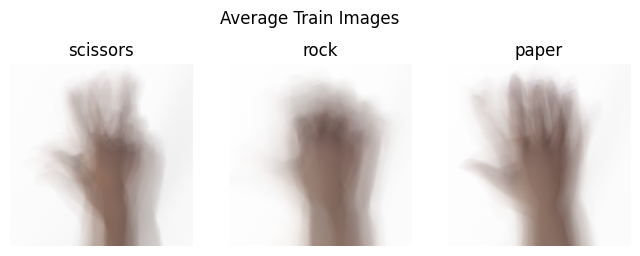

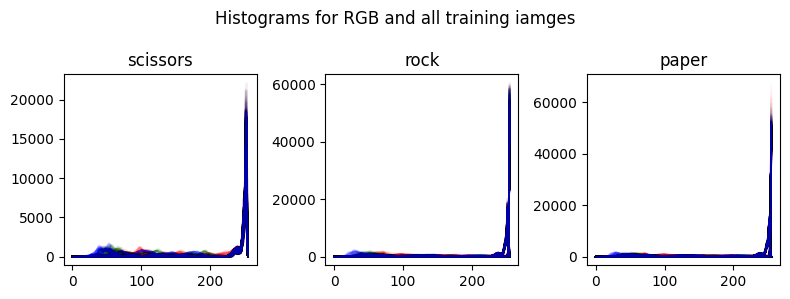

In [69]:
# average images in each class
# calculate histograms for each class
def get_average_image(ds):
    # Initialize a dictionary to hold the class counts
    class_images = {}

    # Get the label names from ds_info
    label_names = ds_info.features['label'].names

    for image, label in ds:
        # Convert the label tensor to a Python integer
        label = label.numpy()

        # Get the label name
        label_name = label_names[label]

        # Add the image to the current images for this label
        class_images[label_name] = class_images.get(label_name, []) + [image.numpy().astype(np.float32)/255.0]

    # Create NumPy arrays to hold the average images for each class
    averages = {}
    histograms = {}

    # Loop through each class
    for cls in class_images:
        # Convert the list of images for this class into a stacked array
        images = np.stack(class_images[cls], axis=0)

        # Compute the mean image for this class
        averages[cls] = np.mean(images, axis=0)

        # Compute histograms for images in this class
        if histograms.get(cls, None) is None:
            histograms[cls] = {}
        histograms[cls]['red'] = [np.histogram(img[...,0], bins=256, range=(0, 1))[0] for img in images]
        histograms[cls]['green'] = [np.histogram(img[...,1], bins=256, range=(0, 1))[0] for img in images]
        histograms[cls]['blue'] = [np.histogram(img[...,2], bins=256, range=(0, 1))[0] for img in images]


    return averages, histograms

# display averaged train images for each class
train_averages, train_histograms = get_average_image(ds_train)
fig, axes = plt.subplots(1, 3, figsize=(8, 3))
for cls, ax in zip(classes, axes):
    ax.imshow(train_averages[cls])
    ax.axis('off')
    ax.set_title(cls)
fig.suptitle('Average Train Images')
fig.show()


# Display histograms for train images for each class
fig, axes = plt.subplots(1, 3, figsize=(8, 3))
for cls, ax in zip(classes, axes):
    # Plot each histogram in a different color
    for hist in train_histograms[cls]['red']:
        ax.plot(hist, color='red', alpha=0.01)
    for hist in train_histograms[cls]['green']:
        ax.plot(hist, color='green', alpha=0.01)
    for hist in train_histograms[cls]['blue']:
        ax.plot(hist, color='blue', alpha=0.01)
    ax.set_title(cls)
fig.suptitle('Histograms for RGB and all training iamges')
fig.show()
fig.tight_layout()


It seems that the images are quite bright and that the hands are in the center of the images. Furthermore, the most of the images seem to have a bright background as bright pixels are dominating the images.

## Augmentations

Trying out various augmentations to see how they affect the images.

- random rotation
- random flip left-right
- random saturation
- random hue
- random brightness
- random contrast


In [111]:
def normalize_image(image, label):
    # Cast the image to float32
    image = tf.cast(image, tf.float32)
    # Normalize the image in the range [0, 1]
    image = image / 255.0
    return image, label

def resize_image(image, label, target_size=(224, 224)):
    image = tf.image.resize(image, target_size)
    return image, label

def augment_image(
        image, 
        label,
        random_flip_left_right=True,
        random_brightness=0.1,
        random_contrast=0.1,
        random_rotation=30,
        random_saturation=0.1,
        random_hue=0.1,
        random_crop=0.1,
        ):
    # Randomly apply augmentations
    
    if random_flip_left_right:
        image = tf.image.random_flip_left_right(image)
    if random_hue is not None:
        image = tf.image.random_hue(image, max_delta=random_hue)
    if random_saturation is not None:
        image = tf.image.random_saturation(image, lower=1-random_saturation, upper=1+random_saturation)
    if random_brightness is not None:
        image = tf.image.random_brightness(image, max_delta=0.1)
    if random_contrast is not None:
        image = tf.image.random_contrast(image, lower=1-random_contrast, upper=1+random_contrast)
    if random_rotation is None or random_rotation > 0:
        # Add a random rotation of +/- X degrees
        degrees = tf.random.uniform([], minval=-random_rotation, maxval=random_rotation)
        radians = degrees * np.pi / 180
        image = tfa.image.rotate(image, radians, fill_mode='nearest')
    if random_crop is not None:
        # retrieve the image size and convert the value to int
        image_size = list(image.shape)[0]
        crop_size = np.round(image_size * (1.0-random_crop), 0).astype(np.int32)
        image = tf.image.random_crop(image, size=[crop_size, crop_size, 3])
    return image, label

def revert_normalize(image, label):
    # Cast to float
    image = tf.cast(image, tf.float32)
    # convert back to original value range
    image = image * 255.0
    image = tf.cast(image, tf.uint8)
    return image, label

In [114]:
target_size = (224, 224)
random_flip_left_right = True
random_brightness = 0.1
random_contrast = 0.1
random_rotation = 30
random_saturation = 0.01
random_hue = 0.1
random_crop = 0.05

ds_train_augmented = ds_train.shuffle(1000, seed=3).take(21).map(
    lambda image, label: resize_image(image, label, target_size)).map(
    normalize_image).map(
    lambda image, label: augment_image(image, label, 
                                       random_flip_left_right=random_flip_left_right, 
                                       random_brightness=random_brightness, 
                                       random_contrast=random_contrast, 
                                       random_rotation=random_rotation,
                                       random_saturation=random_saturation,
                                       random_hue=random_hue,
                                       random_crop=random_crop,))


ds_train_visualize = ds_train_augmented.map(revert_normalize)

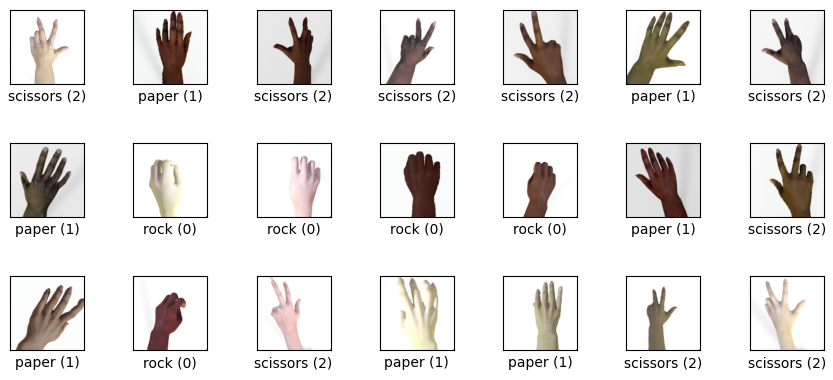

In [115]:
fig = tfds.show_examples(ds_train_visualize, ds_info, rows=3, cols=7, plot_scale=1.5)


We will now check for training our first models.

Please refer to [`README.md`](README.md) and [`notebook-training.ipynb`](notebook-training.ipynb) for the training notebook.